# IITKCourse - Course 2: Marketing Campaign Analysis

This notebook performs exploratory data analysis (EDA), data cleaning, visualization, and hypothesis testing on a marketing campaign dataset.

---

### Problem Statement Summary

- Verify key columns like `Dt_Customer` and `Income`
- Impute missing incomes based on `Education` and `Marital_Status`
- Create new variables: age, total children, total spending, total purchases
- Visualize distributions and treat outliers
- Encode categorical variables
- Generate correlation heatmap
- Test hypotheses on shopping behavior and country spending
- Generate visual insights on product sales, campaign acceptance, and complaints


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('marketing_data.csv', encoding='utf-8-sig')
df.columns = df.columns.str.strip()


In [2]:
# Convert Dt_Customer to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')

# Clean Income column and convert to float
df['Income'] = df['Income'].replace('[\$,]', '', regex=True).astype(float)

# Clean categorical columns
df['Education'] = df['Education'].str.strip().str.title()
df['Marital_Status'] = df['Marital_Status'].str.strip().str.title()

# Impute missing Income using median by Education and Marital_Status
df['Income'] = df.groupby(['Education', 'Marital_Status'])['Income'].transform(lambda x: x.fillna(x.median()))
df.dropna(subset=['Income'], inplace=True)

print('Missing Income after imputation:', df['Income'].isnull().sum())
print(df[['Dt_Customer', 'Income']].info())

Missing Income after imputation: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Dt_Customer  2240 non-null   datetime64[ns]
 1   Income       2240 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 35.1 KB
None


In [3]:
# Create Age, Children, Total Spending, Total Purchases
df['Age'] = dt.datetime.now().year - df['Year_Birth']
df['Children'] = df['Kidhome'] + df['Teenhome']
df['Total_Spending'] = df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
df['Total_Purchases'] = df[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

df.head(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Age,Children,Total_Spending,Total_Purchases
0,1826,1970,Graduation,Divorced,84835.0,0,0,2014-06-16,0,189,...,0,0,0,1,0,SP,55,0,1190,14
1,1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,...,0,0,1,1,0,CA,64,0,577,17
2,10476,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,...,0,0,0,0,0,US,67,1,251,10


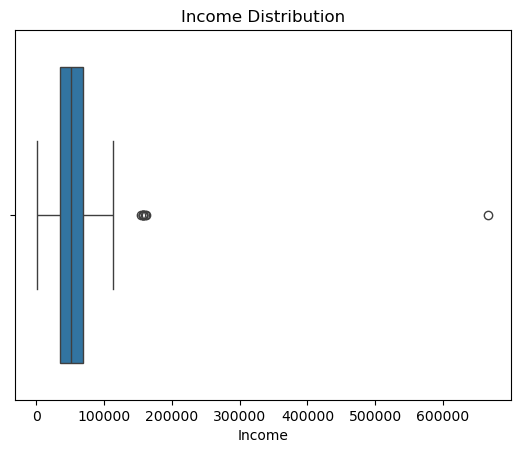

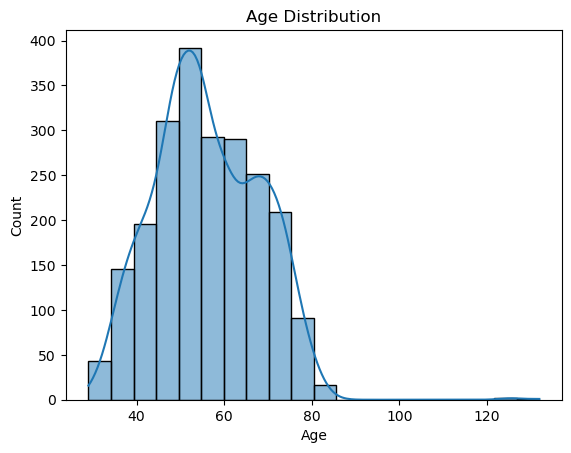

Dataset shape after outlier removal: (2236, 32)


In [4]:
# Visualize Income and Age distributions
sns.boxplot(x=df['Income'])
plt.title('Income Distribution')
plt.show()

sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

# Remove outliers in Age and Income
df = df[(df['Age'] < 100) & (df['Income'] < 200000)]
print('Dataset shape after outlier removal:', df.shape)

In [5]:
# Ordinal encoding for Education
ordinal_map = {'Basic':1, '2N Cycle':2, 'Graduation':3, 'Master':4, 'Phd':5}
df['Education_Ordinal'] = df['Education'].map(ordinal_map)

# One-hot encode Marital_Status and Country
df_encoded = pd.get_dummies(df, columns=['Marital_Status', 'Country'], drop_first=True)
print(df_encoded.head(2))

     ID  Year_Birth   Education   Income  Kidhome  Teenhome Dt_Customer  \
0  1826        1970  Graduation  84835.0        0         0  2014-06-16   
1     1        1961  Graduation  57091.0        0         0  2014-06-15   

   Recency  MntWines  MntFruits  ...  Marital_Status_Together  \
0        0       189        104  ...                    False   
1        0       464          5  ...                    False   

   Marital_Status_Widow  Marital_Status_Yolo  Country_CA  Country_GER  \
0                 False                False       False        False   
1                 False                False        True        False   

   Country_IND  Country_ME  Country_SA  Country_SP  Country_US  
0        False       False       False        True       False  
1        False       False       False       False       False  

[2 rows x 45 columns]


In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

ValueError: could not convert string to float: 'Graduation'

<Figure size 1200x800 with 0 Axes>

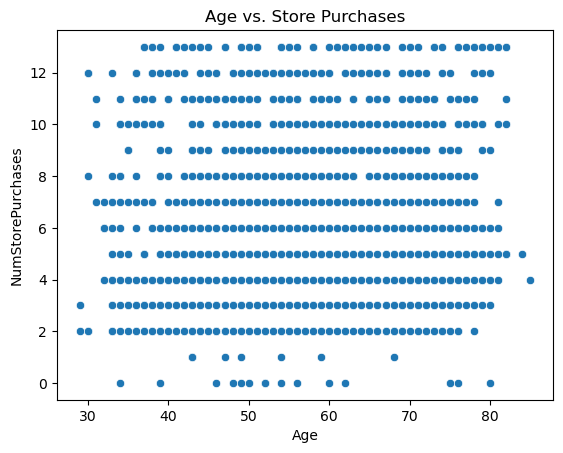

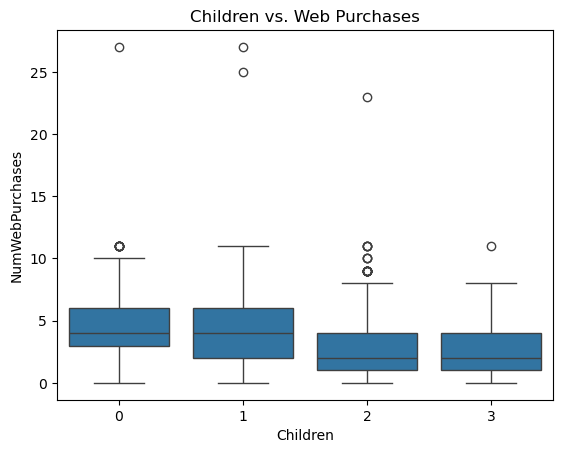

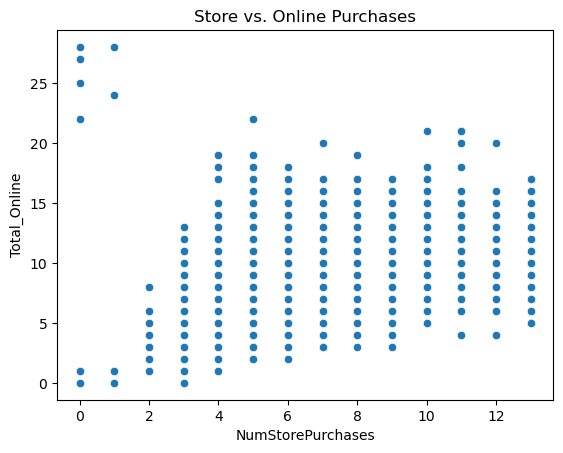

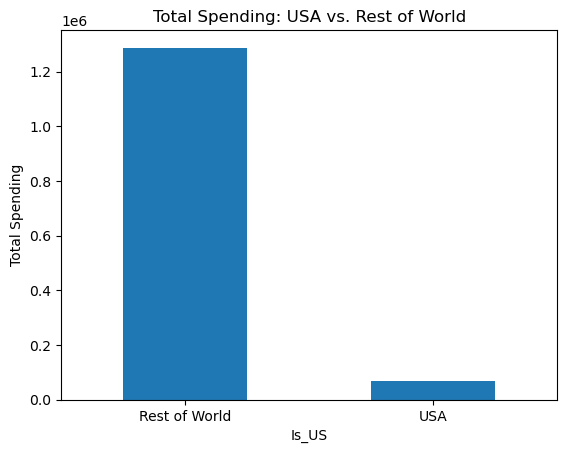

In [7]:
# a) Age vs NumStorePurchases
sns.scatterplot(x='Age', y='NumStorePurchases', data=df)
plt.title('Age vs. Store Purchases')
plt.show()

# b) Children vs NumWebPurchases
sns.boxplot(x='Children', y='NumWebPurchases', data=df)
plt.title('Children vs. Web Purchases')
plt.show()

# c) Store vs Online purchases
df['Total_Online'] = df['NumWebPurchases'] + df['NumCatalogPurchases']
sns.scatterplot(x='NumStorePurchases', y='Total_Online', data=df)
plt.title('Store vs. Online Purchases')
plt.show()

# d) USA vs Rest of World total spending
df['Is_US'] = df['Country'].apply(lambda x: 1 if x.upper() == 'US' else 0)
df.groupby('Is_US')['Total_Spending'].sum().plot(kind='bar')
plt.xticks([0,1], ['Rest of World', 'USA'], rotation=0)
plt.title('Total Spending: USA vs. Rest of World')
plt.ylabel('Total Spending')
plt.show()

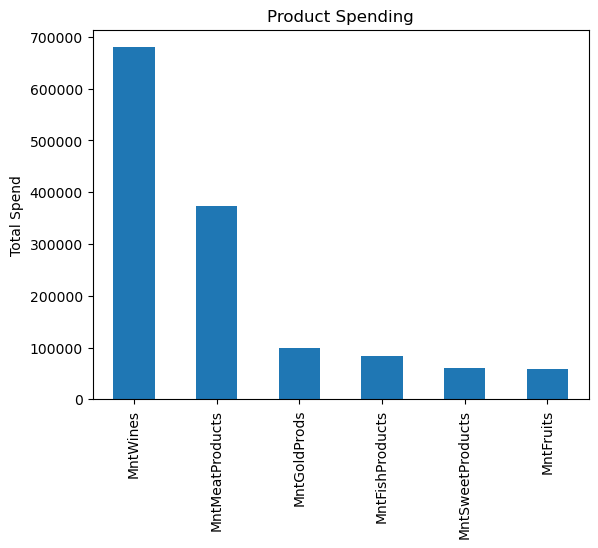

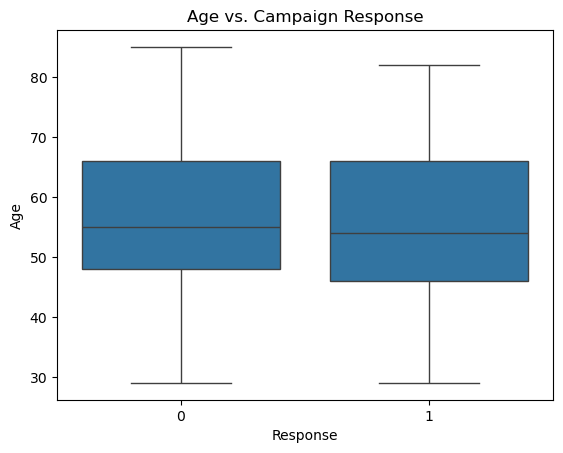

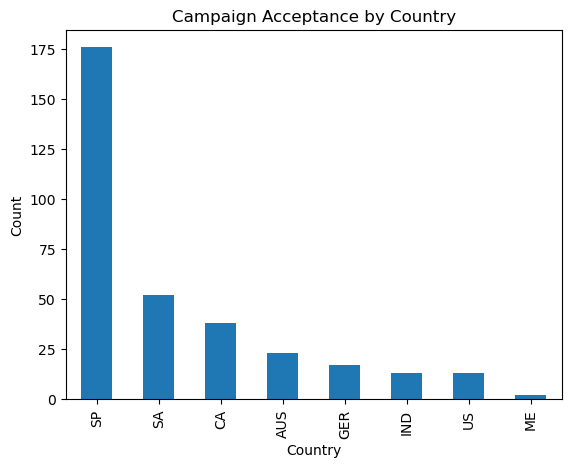

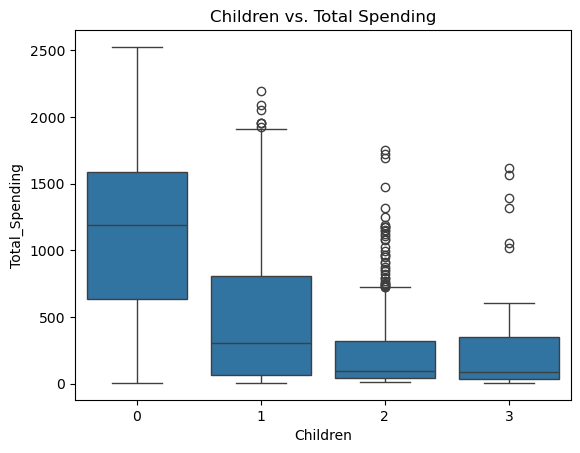

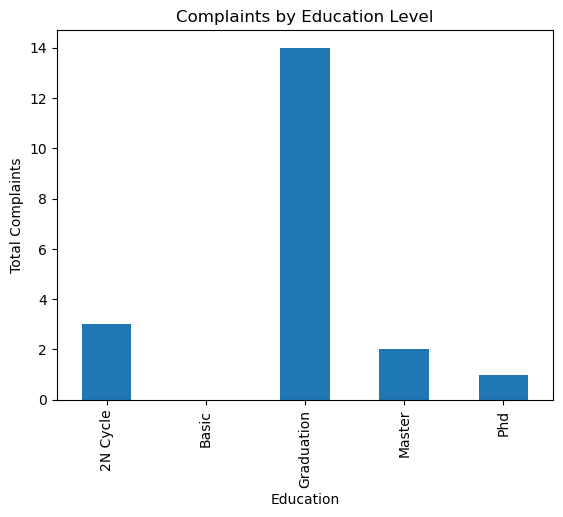

In [8]:
# a) Product spending
df[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Product Spending')
plt.ylabel('Total Spend')
plt.show()

# b) Age vs Campaign response
sns.boxplot(x='Response', y='Age', data=df)
plt.title('Age vs. Campaign Response')
plt.show()

# c) Campaign acceptance by country
df[df['Response']==1]['Country'].value_counts().plot(kind='bar')
plt.title('Campaign Acceptance by Country')
plt.ylabel('Count')
plt.show()

# d) Children vs Total spending
sns.boxplot(x='Children', y='Total_Spending', data=df)
plt.title('Children vs. Total Spending')
plt.show()

# e) Complaints by education level
df.groupby('Education')['Complain'].sum().plot(kind='bar')
plt.title('Complaints by Education Level')
plt.ylabel('Total Complaints')
plt.show()